In [22]:
import numpy as np
from matplotlib import pyplot as plt
import os

from scipy.optimize import minimize  

In [23]:
repodir='/Users/aidasaglinskas/Desktop/BC-Hubs-MentingFang/'


fn = os.path.join(repodir,'Hub_vec_eculid.npy')
hub = np.load(fn)

fn = os.path.join(repodir,'ROI_vec_eculid.npy')
roi = np.load(fn)

print(roi.shape)
print(hub.shape)

(4, 14, 3, 6)
(5, 14, 3, 6)


In [24]:
# 14 Subjects 
# 5 HUBS
# 4 ROIs
# 3 runs
# 6 triu 

#[0][1] # Face-Body
#[1][2] # Body-Object
#[2][3] # Object-Scene
#[1][3] # Body-Scene
#[0][3] # Face-Scene
#[0][2] # Face-Object

In [25]:
#%% Simple Linear Regression Optimisation
def f(x):
    true_a = 5
    true_c = 2
    y = (true_a*x)+true_c
    return y

x = np.array(range(0,10))
y = np.array([f(i) for i in x])

#params = [5,2]
def objective(params):
    a_hat = params[0]
    c_hat = params[1]
    
    y_hat = x*a_hat+c_hat
    err = y_hat-y
    err = np.sum(err**2)
    return err
    
initGuess = [0,0] # Initialize parameters
sol = minimize(objective,initGuess,method='SLSQP') 
print(sol)

     fun: 1.2553938110182162e-14
     jac: array([3.57932422e-06, 4.18896771e-07])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([4.99999999, 2.00000006])


In [26]:
#%% Multiple Regression
def f(xs):
    
    b0 = 5
    b = [1,2,3,4]
    
    Y = b0 + b[0]*xs[0] + b[1]*xs[1] + b[2]*xs[2] + b[3]*xs[3]  # + np.random.randn()
    
    return Y


X = np.array([np.random.randint(20) for i in range(4)])
Y = np.array(f(X))

for i in range(14):
    xs = np.array([np.random.randint(20) for i in range(4)])
    y = np.array(f(xs))
    
    X = np.vstack((X,xs))
    Y = np.append(Y,y)
    
params = [4,1,2,3,4]
def objective(params):
    
    b0 = params[0]
    b = params[1:]

    y_hat = b0 + X[:,0]*b[0] + X[:,1]*b[1] + X[:,2]*b[2] + X[:,3]*b[3]
    
    err = Y-y_hat
    sum_sq = np.sum(err**2)
    
    return sum_sq


initGuess = [0,1,2,3,4]
sol = minimize(objective,initGuess,method='SLSQP') 
print(sol)

     fun: 2.5227358982626225e-12
     jac: array([ 6.17094997e-09, -2.42562237e-09, -1.46471848e-08,  1.12958389e-08,
       -1.46611399e-08])
 message: 'Optimization terminated successfully.'
    nfev: 70
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([5.00000176, 0.99999996, 1.99999995, 2.99999997, 3.99999996])


In [27]:
#fn = '/Users/aidasaglinskas/Desktop/MentingFang/Hub_vec.npy'
#hub = np.load(fn)

#fn = '/Users/aidasaglinskas/Desktop/MentingFang/ROI_vec.npy'
#roi = np.load(fn)

hub.shape
roi.shape

rlbls = ['roi 1','roi 2','roi 3','roi 4']
rlbls = ['FACE','BODY','OBJECT','SCENE']

hlbls = ['hub 1','hub 2','hub 3','hub 4','hub 5']
hlbls = ['Thalamus', 'Middle Cingulate', 'Posterior Cingulate', 'Angular Gyrus', 'Cerebellum']

In [28]:
def get_X_matrix(roi_ind,run_ind):
#    roi_ind = 0
#    run_ind = 0
    X = np.zeros([14,6])
    for subject in range(roi.shape[1]):
        for dist in range(roi.shape[3]):
            X[subject,dist] = roi[roi_ind,subject,run_ind,dist]
    return X

def get_Y_matrix(hub_ind,run_ind):
#    hub_ind = 0
#    run_ind = 0
    Y = np.zeros([14,6])
    for subject in range(hub.shape[1]):
        for dist in range(roi.shape[3]):
            Y[subject,dist] = hub[hub_ind,subject,run_ind,dist]
    return Y

In [29]:
def optimal_betas(hub_ind,run_ind):
    X1,X2,X3,X4 = [get_X_matrix(0,run_ind),get_X_matrix(1,run_ind),get_X_matrix(2,run_ind),get_X_matrix(3,run_ind)]
    Y = np.array(get_Y_matrix(hub_ind,run_ind))
    
    params = np.array([1,2,3,4,5])
    def objective(params):
        b0 = params[0]
        b = params[1:] # from 1 to end
        #params[0] = 0
        Y_hat = params[0] + X1*params[1] + X2*params[2] + X3*params[3] + X4*params[4]
        err = Y-Y_hat
        sum_sq = np.sum(err**2)
        return sum_sq
    
    
    initGuess = [10,10,10,10,10]
    sol = minimize(objective,initGuess,method='SLSQP') 
    #print(sol.success)
    #print(sol.fun)
    #print(sol.x)

    return sol.x

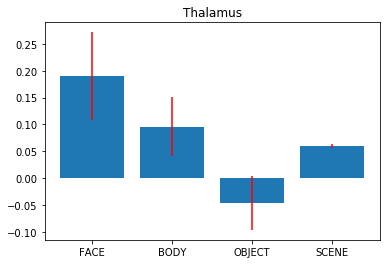

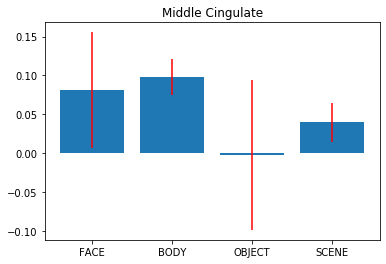

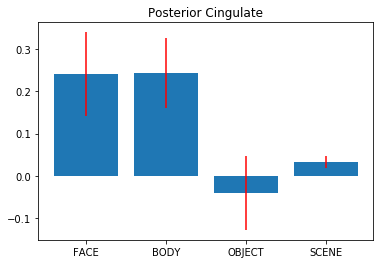

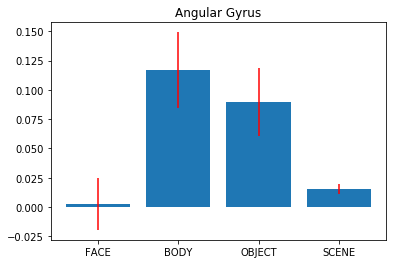

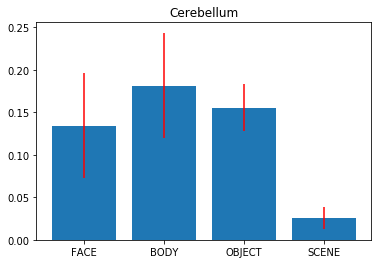

In [30]:
from matplotlib import pyplot as plt

for hub_ind in range(5):
    betas = optimal_betas(hub_ind,0)
    betas = np.vstack((betas,optimal_betas(hub_ind,1)))
    betas = np.vstack((betas,optimal_betas(hub_ind,2)))
    #print(betas.shape)

    m = np.mean(betas,axis=0)
    m = m[1:]
    sd = np.std(betas,axis=0)
    sd = sd[1:] /np.sqrt(3)
    
    fig, axs = plt.subplots()
    plt.bar([1,2,3,4],m)
    #plt.hold
    plt.errorbar([1,2,3,4],y=m,yerr=sd,fmt='none',ecolor='r')
    plt.title(hlbls[hub_ind])
    axs.xaxis.set_ticks([1,2,3,4])
    axs.xaxis.set_ticklabels(rlbls)
    plt.show

In [31]:
# Across subs,runs,and Triu simultaneusly Y = 3dmatrix(subj,runs,triu)*beta
hub_ind = 0

hub.shape
roi.shape

#roi = roi-np.mean(roi,2,keepdims=True)
#hub = hub-np.mean(hub,2,keepdims=True)

#roi = roi-np.mean(roi,1,keepdims=True)
#hub = hub-np.mean(hub,1,keepdims=True)

#roi = roi-np.mean(roi,0,keepdims=True)
#hub = hub-np.mean(hub,0,keepdims=True)

def objective(params):
    b0 = params[0]
    b = params[1:]
    #b0=0
    y_hat = b0 + roi[0,:,:,:]*b[0] + roi[1,:,:,:]*b[1] + roi[2,:,:,:]*b[2] + roi[3,:,:,:]*b[3]
    y = hub[hub_ind,:,:,:]
    err = np.sum(y_hat-y**2)
    
    return err

initGuess = [2,2,2,2,2]
sol = minimize(objective,initGuess,method='SLSQP') 
print(sol.success)
print(sol.fun)
print(sol.x)

True
-2290235158238.2773
[  -729628.34153852 -42436217.80318509 -37302200.51878435
 -28056416.38342848 -48908834.400281  ]
